In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime, timedelta
from scipy import stats

In [2]:
# Set plotting style
plt.style.use('ggplot')
sns.set(style="whitegrid")

LOAD THE DATASETS

In [3]:
# Read the transcation data into a pandas Dataframe
file_path = "D:/Quantium/" 
transaction_data = pd.read_csv(file_path + "QVI_transaction_data.csv")


In [4]:
# Convert DATE column from Excel-style integers to datetime
transaction_data['DATE'] = pd.to_datetime(transaction_data['DATE'], origin='1899-12-30', unit='D')

In [18]:
transaction_data.head(10)

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
5,2019-05-19,4,4074,2982,57,Old El Paso Salsa Dip Tomato Mild 300g,1,5.1
6,2019-05-16,4,4149,3333,16,Smiths Crinkle Chips Salt & Vinegar 330g,1,5.7
7,2019-05-16,4,4196,3539,24,Grain Waves Sweet Chilli 210g,1,3.6
8,2018-08-20,5,5026,4525,42,Doritos Corn Chip Mexican Jalapeno 150g,1,3.9
9,2018-08-18,7,7150,6900,52,Grain Waves Sour Cream&Chives 210G,2,7.2


In [5]:
# Read the customer data into a panda DataFrame
customer_data = pd.read_csv(file_path + "QVI_purchase_behaviour.csv")

customer_data.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


TEXT ANALYSIS ON PRODUCT NAMES TO VERIFY THEY ARE CHIPS

In [6]:
# Examine PROD_NAME to check we're looking at the right products
print(transaction_data['PROD_NAME'].value_counts().head(10))

PROD_NAME
Kettle Mozzarella   Basil & Pesto 175g      3304
Kettle Tortilla ChpsHny&Jlpno Chili 150g    3296
Cobs Popd Swt/Chlli &Sr/Cream Chips 110g    3269
Tyrrells Crisps     Ched & Chives 165g      3268
Cobs Popd Sea Salt  Chips 110g              3265
Kettle 135g Swt Pot Sea Salt                3257
Tostitos Splash Of  Lime 175g               3252
Infuzions Thai SweetChili PotatoMix 110g    3242
Smiths Crnkle Chip  Orgnl Big Bag 380g      3233
Thins Potato Chips  Hot & Spicy 175g        3229
Name: count, dtype: int64


In [7]:
# Extract all unique words from product names
all_product_words = ' '.join(transaction_data['PROD_NAME'].unique()).split()
product_words = pd.Series(all_product_words)

In [8]:
# Remove digits and special characters from product words and count frequency
clean_words = product_words[~product_words.str.contains(r'[0-9&]')]
word_counts = clean_words.value_counts().sort_values(ascending=False)
print("Most common words in product names:")
print(word_counts.head(20))

Most common words in product names:
Chips       21
Smiths      16
Crinkle     14
Cut         14
Kettle      13
Salt        12
Cheese      12
Original    10
Salsa        9
Chip         9
Doritos      9
Corn         8
Pringles     8
RRD          8
Chicken      7
WW           7
Sea          6
Sour         6
Vinegar      5
Crisps       5
Name: count, dtype: int64


In [9]:
# Remove salsa products as we're only interested in chips
transaction_data['SALSA'] = transaction_data['PROD_NAME'].str.lower().str.contains('salsa')
transaction_data = transaction_data[~transaction_data['SALSA']].drop('SALSA', axis=1)

CHECK THE NULL

In [10]:
print("Null values in transaction data:")
transaction_data.isnull().sum()

Null values in transaction data:


DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

SUMARIZE DATASET

In [11]:
transaction_data.describe()


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246742,246742.000000,2.467420e+05,2.467420e+05,246742.000000,246742.000000,246742.000000
mean,2018-12-30 01:19:01.211467520,135.051098,1.355310e+05,1.351311e+05,56.351789,1.908062,7.321322
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756925e+04,26.000000,2.000000,5.800000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351830e+05,53.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030840e+05,2.026538e+05,87.000000,2.000000,8.800000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000
std,NaN,76.787096,8.071528e+04,7.814772e+04,33.695428,0.659831,3.077828


EXAMINE THE OUTLIERS

In [12]:
# Investigate transaction with 200 packets of chips
outlier_transactions = transaction_data[transaction_data['PROD_QTY'] >= 200]
print("Outlier transactions:")
outlier_transactions

Outlier transactions:


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [13]:
# Check if the customer with outlier transactions has other purchases
outlier_customer = outlier_transactions['LYLTY_CARD_NBR'].iloc[0]
customer_transactions = transaction_data[transaction_data['LYLTY_CARD_NBR'] == outlier_customer]
print(f"All transactions by customer {outlier_customer}:")
customer_transactions

All transactions by customer 226000:


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


In [14]:
# Filter out the outlier customer
transaction_data = transaction_data[transaction_data['LYLTY_CARD_NBR'] != outlier_customer]
print("Transaction data stats after removing outlier customer:")
transaction_data.describe()

Transaction data stats after removing outlier customer:


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246740,246740.000000,2.467400e+05,2.467400e+05,246740.000000,246740.000000,246740.000000
mean,2018-12-30 01:18:58.448569344,135.050361,1.355303e+05,1.351304e+05,56.352213,1.906456,7.316113
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756875e+04,26.000000,2.000000,5.800000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351815e+05,53.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030832e+05,2.026522e+05,87.000000,2.000000,8.800000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,5.000000,29.500000
std,NaN,76.786971,8.071520e+04,7.814760e+04,33.695235,0.342499,2.474897


In [15]:
# Count transactions by date to check for data issues
transactions_by_day = transaction_data.groupby('DATE').size().reset_index(name='N')
transactions_by_day.head()

,DATE,N
0,2018-07-01,663
1,2018-07-02,650
2,2018-07-03,674
3,2018-07-04,669
4,2018-07-05,660


In [16]:
# Create a sequence of dates to identify any missing dates
date_range = pd.date_range(start='2018-07-01', end='2019-06-30')
date_df = pd.DataFrame({'DATE': date_range})

In [17]:
# Merge to find missing dates
transactions_by_day_full = pd.merge(date_df, transactions_by_day, on='DATE', how='left').fillna(0)
print("Missing dates:")
transactions_by_day_full[transactions_by_day_full['N'] == 0]

Missing dates:


,DATE,N
177,2018-12-25,0.0


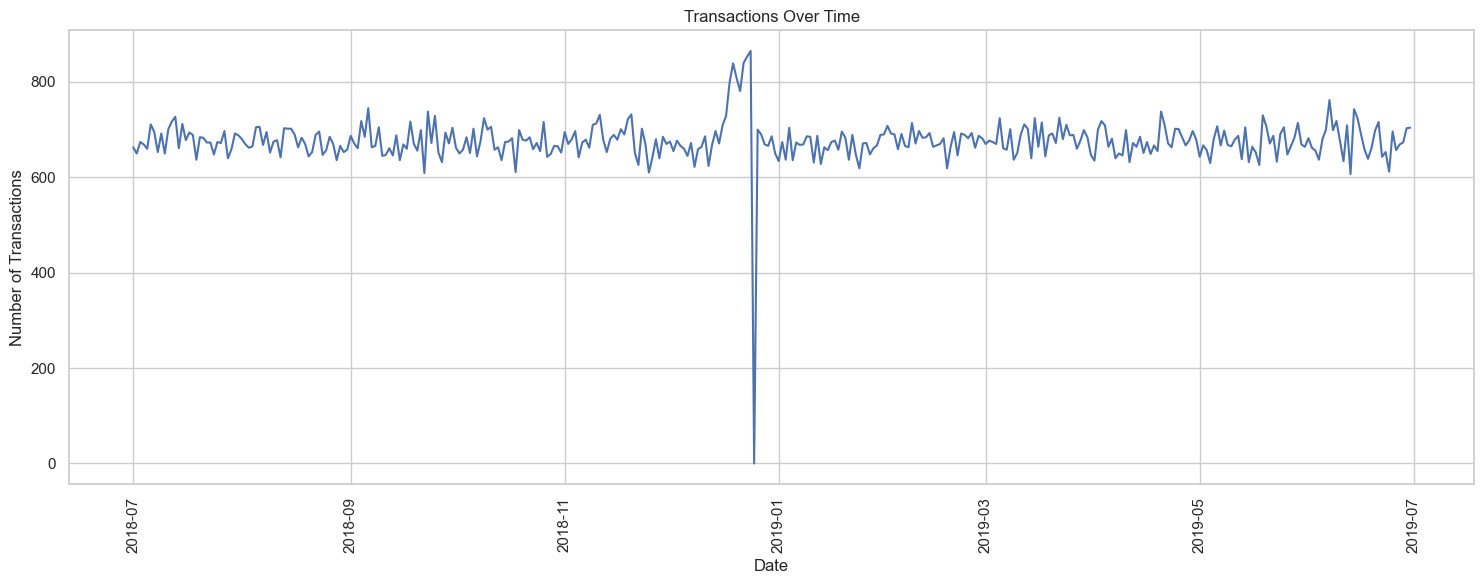

In [18]:
# Plot transactions over time
plt.figure(figsize=(15, 6))
plt.plot(transactions_by_day_full['DATE'], transactions_by_day_full['N'])
plt.title('Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

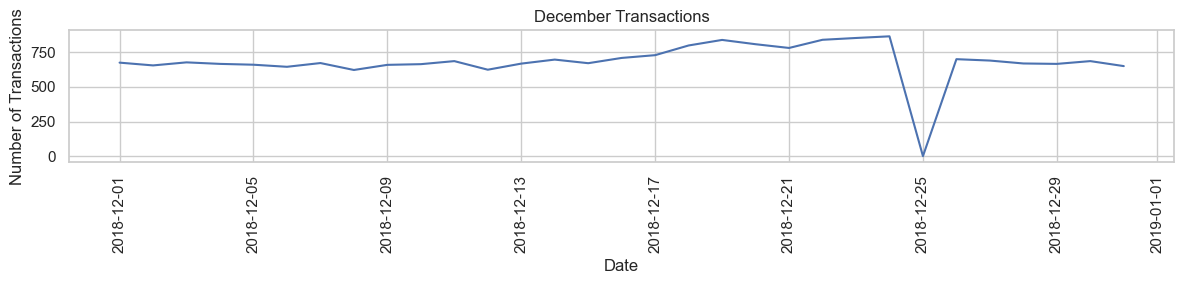

In [22]:
# Zoom in on December data
dec_data = transactions_by_day_full[(transactions_by_day_full['DATE'] >= '2018-12-01') & 
                                   (transactions_by_day_full['DATE'] <= '2018-12-31')]
plt.figure(figsize=(12, 3))
plt.plot(dec_data['DATE'], dec_data['N'])
plt.title('December Transactions')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [23]:
# Create pack size from PROD_NAME
def extract_pack_size(product_name):
    # Look for numbers in the product name
    match = re.search(r'(\d+)(g|kg|G|KG)', product_name)
    if match:
        size = match.group(1)
        unit = match.group(2).lower()
        # Convert to grams if in kg
        if unit == 'kg':
            return int(float(size) * 1000)
        return int(size)
    return None

In [24]:
transaction_data['PACK_SIZE'] = transaction_data['PROD_NAME'].apply(extract_pack_size)

In [25]:
# Check pack sizes
pack_size_counts = transaction_data['PACK_SIZE'].value_counts().sort_index()
print("Pack size distribution:")
print(pack_size_counts)

Pack size distribution:
PACK_SIZE
70      1507
90      3008
110    22387
125     1454
134    25102
135     3257
150    40203
160     2970
165    15297
170    19983
175    66390
180     1468
190     2995
200     4473
210     6272
220     1564
250     3169
270     6285
330    12540
380     6416
Name: count, dtype: int64


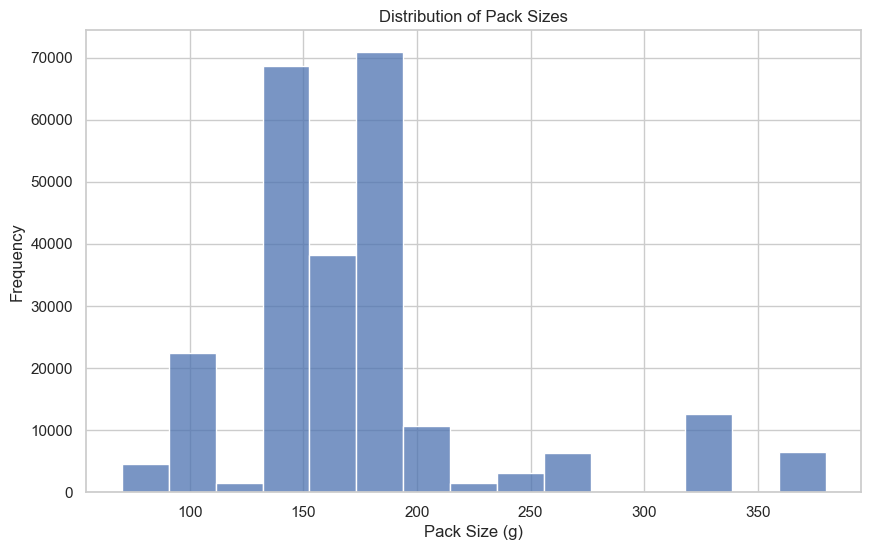

In [26]:
# Plot histogram of pack sizes
plt.figure(figsize=(10, 6))
sns.histplot(transaction_data['PACK_SIZE'], bins=15)
plt.title('Distribution of Pack Sizes')
plt.xlabel('Pack Size (g)')
plt.ylabel('Frequency')
plt.show()

In [27]:
# Extract brand from product name (first word)
transaction_data['BRAND'] = transaction_data['PROD_NAME'].apply(lambda x: x.split()[0])
brand_counts = transaction_data['BRAND'].value_counts()
print("Brand distribution:")
print(brand_counts)

Brand distribution:
BRAND
Kettle        41288
Smiths        27390
Pringles      25102
Doritos       22041
Thins         14075
RRD           11894
Infuzions     11057
WW            10320
Cobs           9693
Tostitos       9471
Twisties       9454
Tyrrells       6442
Grain          6272
Natural        6050
Cheezels       4603
CCs            4551
Red            4427
Dorito         3183
Infzns         3144
Smith          2963
Cheetos        2927
Snbts          1576
Burger         1564
Woolworths     1516
GrnWves        1468
Sunbites       1432
NCC            1419
French         1418
Name: count, dtype: int64


In [28]:
# Clean brand names - combine similar brands
# RED and RRD are both Red Rock Deli
transaction_data.loc[transaction_data['BRAND'] == 'RED', 'BRAND'] = 'RRD'
# Add other brand adjustments if needed
# For example, if there are other variations like Dorito/Doritos:
# transaction_data.loc[transaction_data['BRAND'] == 'Dorito', 'BRAND'] = 'Doritos'

In [29]:
# Check the cleaned brands
print("Cleaned brand distribution:")
print(transaction_data['BRAND'].value_counts())

Cleaned brand distribution:
BRAND
Kettle        41288
Smiths        27390
Pringles      25102
Doritos       22041
Thins         14075
RRD           11894
Infuzions     11057
WW            10320
Cobs           9693
Tostitos       9471
Twisties       9454
Tyrrells       6442
Grain          6272
Natural        6050
Cheezels       4603
CCs            4551
Red            4427
Dorito         3183
Infzns         3144
Smith          2963
Cheetos        2927
Snbts          1576
Burger         1564
Woolworths     1516
GrnWves        1468
Sunbites       1432
NCC            1419
French         1418
Name: count, dtype: int64


In [30]:
# Examine customer data
customer_data.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [31]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [32]:
customer_data.describe()

,LYLTY_CARD_NBR
count,7.263700e+04
mean,1.361859e+05
std,8.989293e+04
min,1.000000e+03
25%,6.620200e+04
50%,1.340400e+05
75%,2.033750e+05
max,2.373711e+06


In [33]:
# Merge transaction data with customer data
data = pd.merge(transaction_data, customer_data, how='left')

In [34]:
# Check if all transactions have customer data
print("Number of transactions without customer data:") 
data.isnull().sum()

Number of transactions without customer data:


DATE                0
STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [35]:
# Calculate total sales by customer segments
segment_sales = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()
print("Total sales by customer segment:")
segment_sales

Total sales by customer segment:


,LIFESTAGE,PREMIUM_CUSTOMER,TOT_SALES
0,MIDAGE SINGLES/COUPLES,Budget,33345.70
1,MIDAGE SINGLES/COUPLES,Mainstream,84734.25
2,MIDAGE SINGLES/COUPLES,Premium,54443.85
3,NEW FAMILIES,Budget,20607.45
4,NEW FAMILIES,Mainstream,15979.70
5,NEW FAMILIES,Premium,10760.80
6,OLDER FAMILIES,Budget,156863.75
7,OLDER FAMILIES,Mainstream,96413.55
8,OLDER FAMILIES,Premium,75242.60
9,OLDER SINGLES/COUPLES,Budget,127833.60


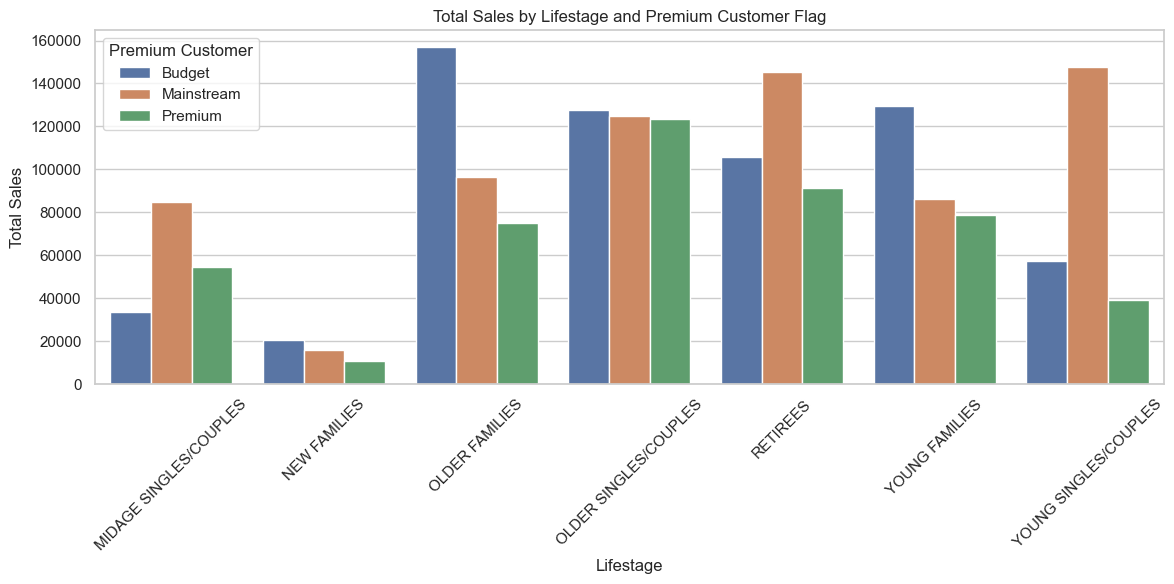

In [56]:
# Plot total sales by segment
plt.figure(figsize=(12, 6))
sns.barplot(x='LIFESTAGE', y='TOT_SALES', hue='PREMIUM_CUSTOMER', data=segment_sales)
plt.title('Total Sales by Lifestage and Premium Customer Flag')
plt.xlabel('Lifestage')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.legend(title='Premium Customer')
plt.tight_layout()
plt.show()

In [37]:
# Count number of unique customers by segment
customer_counts = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique().reset_index()
customer_counts.rename(columns={'LYLTY_CARD_NBR': 'CUSTOMER_COUNT'}, inplace=True)
print("Number of customers by segment:")
customer_counts

Number of customers by segment:


,LIFESTAGE,PREMIUM_CUSTOMER,CUSTOMER_COUNT
0,MIDAGE SINGLES/COUPLES,Budget,1474
1,MIDAGE SINGLES/COUPLES,Mainstream,3298
2,MIDAGE SINGLES/COUPLES,Premium,2369
3,NEW FAMILIES,Budget,1087
4,NEW FAMILIES,Mainstream,830
5,NEW FAMILIES,Premium,575
6,OLDER FAMILIES,Budget,4611
7,OLDER FAMILIES,Mainstream,2788
8,OLDER FAMILIES,Premium,2231
9,OLDER SINGLES/COUPLES,Budget,4849


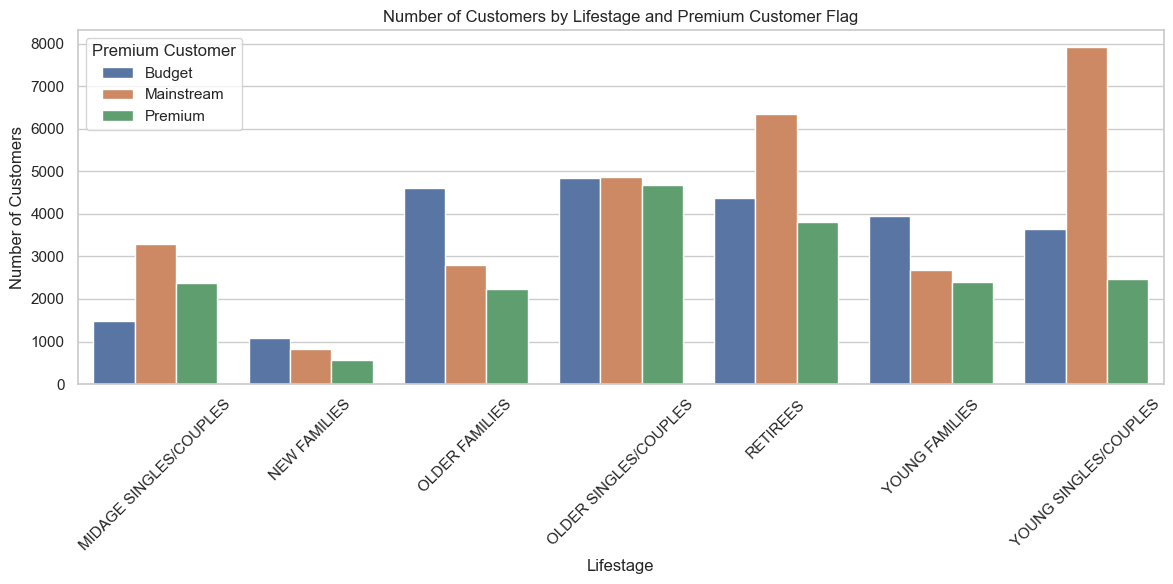

In [57]:
# Plot number of customers by segment
plt.figure(figsize=(12, 6))
sns.barplot(x='LIFESTAGE', y='CUSTOMER_COUNT', hue='PREMIUM_CUSTOMER', data=customer_counts)
plt.title('Number of Customers by Lifestage and Premium Customer Flag')
plt.xlabel('Lifestage')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.legend(title='Premium Customer')
plt.tight_layout()
plt.show()

In [39]:
# Calculate average units per customer by segment
# First, get total units by segment
segment_units = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PROD_QTY'].sum().reset_index()
# Merge with customer counts
units_per_customer = pd.merge(segment_units, customer_counts)
units_per_customer['UNITS_PER_CUSTOMER'] = units_per_customer['PROD_QTY'] / units_per_customer['CUSTOMER_COUNT']

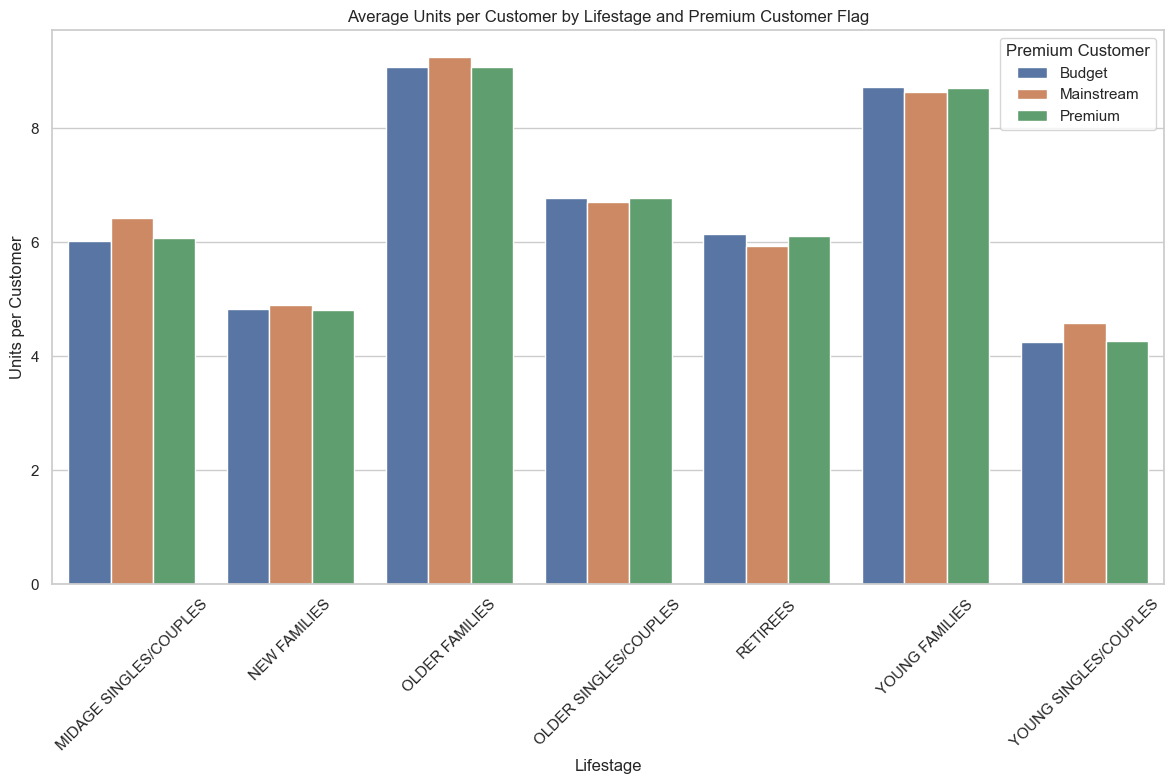

In [40]:
# Plot average units per customer by segment
plt.figure(figsize=(12, 8))
sns.barplot(x='LIFESTAGE', y='UNITS_PER_CUSTOMER', hue='PREMIUM_CUSTOMER', data=units_per_customer)
plt.title('Average Units per Customer by Lifestage and Premium Customer Flag')
plt.xlabel('Lifestage')
plt.ylabel('Units per Customer')
plt.xticks(rotation=45)
plt.legend(title='Premium Customer')
plt.tight_layout()
plt.show()

In [41]:
# Calculate average price per unit by segment
data['PRICE_PER_UNIT'] = data['TOT_SALES'] / data['PROD_QTY']
avg_price_by_segment = data.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PRICE_PER_UNIT'].mean().reset_index()

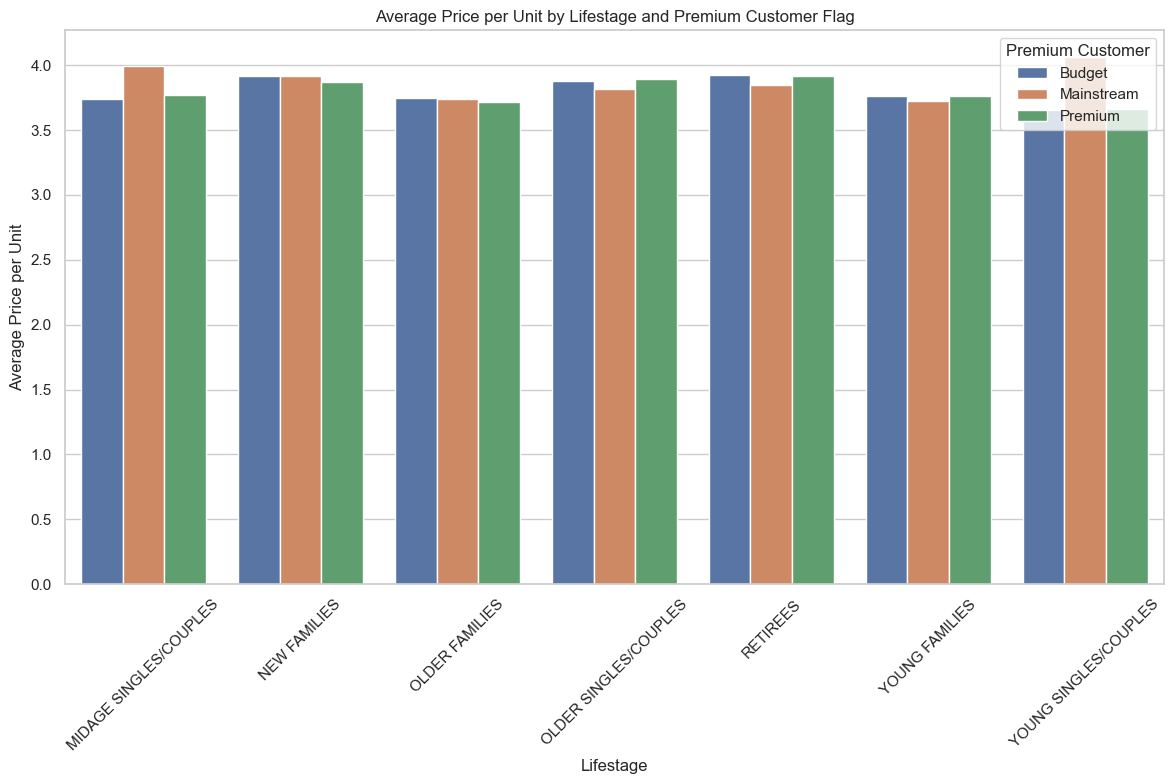

In [42]:
# Plot average price per unit by segment
plt.figure(figsize=(12, 8))
sns.barplot(x='LIFESTAGE', y='PRICE_PER_UNIT', hue='PREMIUM_CUSTOMER', data=avg_price_by_segment)
plt.title('Average Price per Unit by Lifestage and Premium Customer Flag')
plt.xlabel('Lifestage')
plt.ylabel('Average Price per Unit')
plt.xticks(rotation=45)
plt.legend(title='Premium Customer')
plt.tight_layout()
plt.show()

In [43]:
# Statistical test: Comparing mainstream vs premium/budget for young singles/couples and midage singles/couples
# Filter data for the segments of interest
target_segments = data[
    (data['LIFESTAGE'].isin(['YOUNG SINGLES/COUPLES', 'MIDAGE SINGLES/COUPLES'])) &
    (data['PREMIUM_CUSTOMER'].isin(['Mainstream', 'Budget', 'Premium']))
]

In [44]:
# Split into mainstream vs. others
mainstream = target_segments[target_segments['PREMIUM_CUSTOMER'] == 'Mainstream']['PRICE_PER_UNIT']
other = target_segments[target_segments['PREMIUM_CUSTOMER'] != 'Mainstream']['PRICE_PER_UNIT']

In [45]:
# Perform t-test
t_stat, p_value = stats.ttest_ind(mainstream, other, equal_var=False)
print(f"T-test result: t-statistic = {t_stat}, p-value = {p_value}")
significance = "significant" if p_value < 0.05 else "not significant"
print(f"The difference in unit price is {significance} at the 5% level.")

T-test result: t-statistic = 37.6243885962295, p-value = 6.967354233018139e-306
The difference in unit price is significant at the 5% level.


In [46]:
# Deep dive into Mainstream young singles/couples
# Brand affinity analysis
# Filter for the target segment
target_segment = data[
    (data['LIFESTAGE'] == 'YOUNG SINGLES/COUPLES') & 
    (data['PREMIUM_CUSTOMER'] == 'Mainstream')
]

In [47]:
# Count brands for target segment
target_brands = target_segment.groupby('BRAND')['PROD_QTY'].sum().reset_index()
# Count brands for all customers
total_brands = data.groupby('BRAND')['PROD_QTY'].sum().reset_index()
# Merge to calculate affinity
brand_affinity = pd.merge(target_brands, total_brands, on='BRAND', suffixes=('_target', '_total'))
brand_affinity['target_proportion'] = brand_affinity['PROD_QTY_target'] / brand_affinity['PROD_QTY_target'].sum()
brand_affinity['total_proportion'] = brand_affinity['PROD_QTY_total'] / brand_affinity['PROD_QTY_total'].sum()
brand_affinity['affinity'] = brand_affinity['target_proportion'] / brand_affinity['total_proportion']
brand_affinity = brand_affinity.sort_values('affinity', ascending=False)

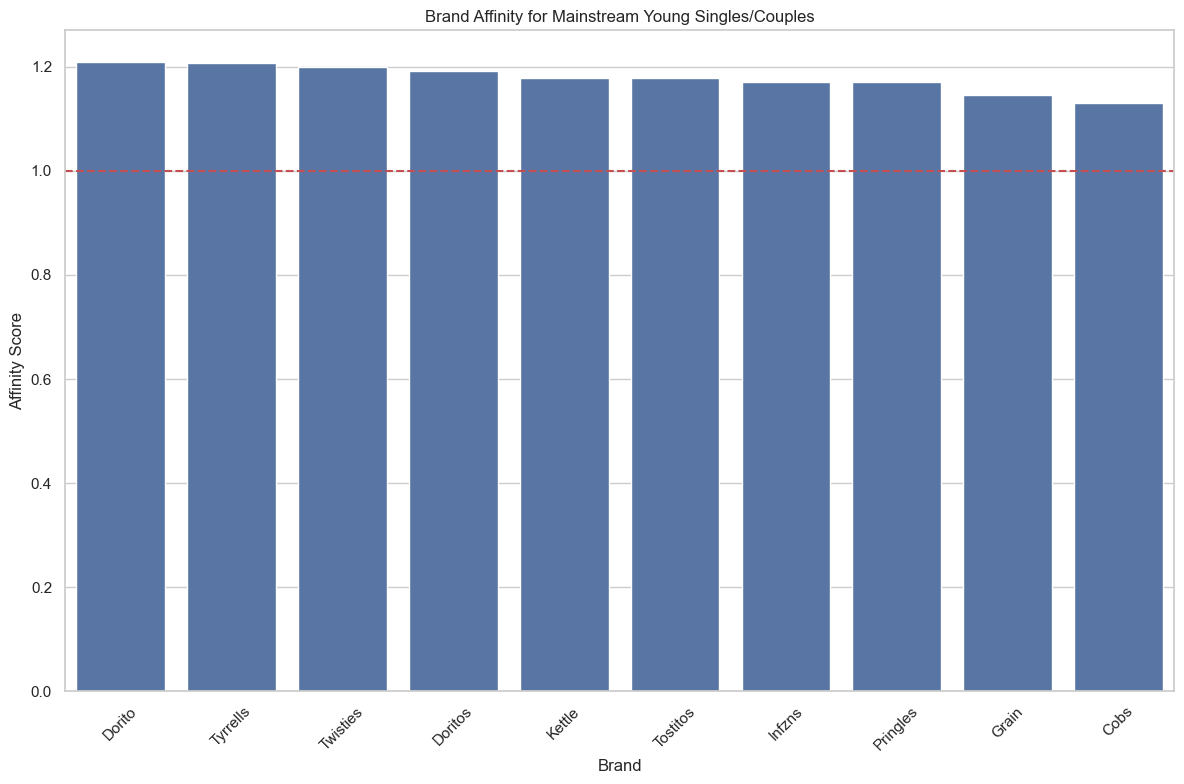

In [48]:
# Plot brand affinity
plt.figure(figsize=(12, 8))
sns.barplot(x='BRAND', y='affinity', data=brand_affinity.head(10))
plt.title('Brand Affinity for Mainstream Young Singles/Couples')
plt.xlabel('Brand')
plt.ylabel('Affinity Score')
plt.xticks(rotation=45)
plt.axhline(y=1, color='r', linestyle='--')
plt.tight_layout()
plt.show()

In [49]:
# Pack size preference analysis
# Count pack sizes for target segment
target_pack_sizes = target_segment.groupby('PACK_SIZE')['PROD_QTY'].sum().reset_index()
# Count pack sizes for all customers
total_pack_sizes = data.groupby('PACK_SIZE')['PROD_QTY'].sum().reset_index()
# Merge to calculate affinity
pack_size_affinity = pd.merge(target_pack_sizes, total_pack_sizes, on='PACK_SIZE', suffixes=('_target', '_total'))
pack_size_affinity['target_proportion'] = pack_size_affinity['PROD_QTY_target'] / pack_size_affinity['PROD_QTY_target'].sum()
pack_size_affinity['total_proportion'] = pack_size_affinity['PROD_QTY_total'] / pack_size_affinity['PROD_QTY_total'].sum()
pack_size_affinity['affinity'] = pack_size_affinity['target_proportion'] / pack_size_affinity['total_proportion']
pack_size_affinity = pack_size_affinity.sort_values('affinity', ascending=False)

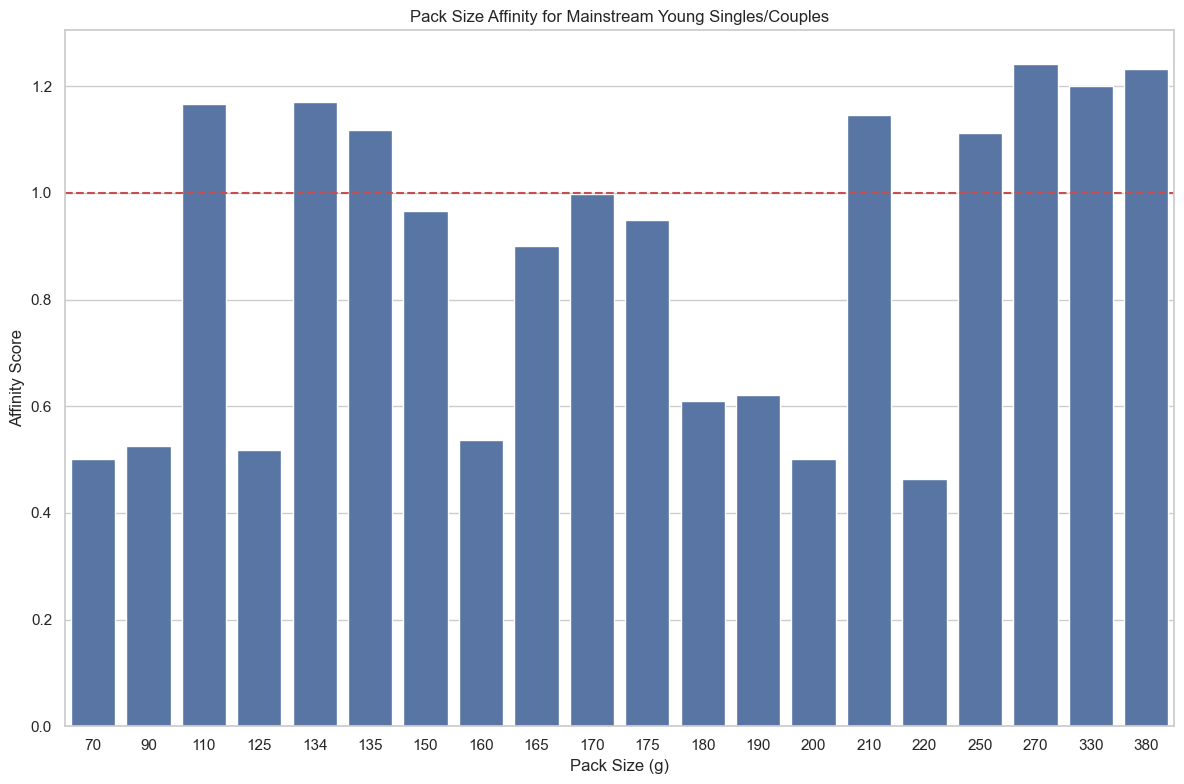

In [50]:
# Plot pack size affinity
plt.figure(figsize=(12, 8))
sns.barplot(x='PACK_SIZE', y='affinity', data=pack_size_affinity)
plt.title('Pack Size Affinity for Mainstream Young Singles/Couples')
plt.xlabel('Pack Size (g)')
plt.ylabel('Affinity Score')
plt.axhline(y=1, color='r', linestyle='--')
plt.tight_layout()
plt.show()

In [51]:
# Save the processed dataset for future tasks
data.to_csv(file_path + "QVI_data_processed.csv", index=False)

In [52]:
# Print key insights
print("\n--- KEY INSIGHTS ---")
print("1. Sales are mainly from Budget-older families, Mainstream-young singles/couples, and Mainstream-retirees.")
print("2. Older families and young families generally buy more chips per customer.")
print("3. Mainstream young singles/couples tend to pay more per packet of chips.")
print(f"4. The t-test confirms that the price difference is {significance}.")
print(f"5. Brands with highest affinity for Mainstream young singles/couples: {', '.join(brand_affinity.head(3)['BRAND'].tolist())}")
print(f"6. Pack sizes with highest affinity for this segment: {', '.join(map(str, pack_size_affinity.head(3)['PACK_SIZE'].tolist()))} grams")


--- KEY INSIGHTS ---
1. Sales are mainly from Budget-older families, Mainstream-young singles/couples, and Mainstream-retirees.
2. Older families and young families generally buy more chips per customer.
3. Mainstream young singles/couples tend to pay more per packet of chips.
4. The t-test confirms that the price difference is significant.
5. Brands with highest affinity for Mainstream young singles/couples: Dorito, Tyrrells, Twisties
6. Pack sizes with highest affinity for this segment: 270, 380, 330 grams
